In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklego.linear_model import LADRegression
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("StudentPerformanceFactorsCleaned.csv")
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Female,70


We first split the data into training, validation, and testing.

In [3]:
y = df["Exam_Score"]

#60% for training
df_train = df.sample(frac=0.6, random_state=2)

tmp = df.query("~index.isin(@df_train.index)")

#20% for validation
df_validation = tmp.sample(frac=0.5, random_state=3789)

#20% for testing
df_test = tmp.query("~index.isin(@df_validation.index)")

print(f"Training data: {df_train.shape}")
print(f"Validation data: {df_validation.shape}")
print(f"Testing data: {df_test.shape}")

Training data: (3866, 19)
Validation data: (1288, 19)
Testing data: (1289, 19)


We now fit it with Linear Regression, and make predictions on the validation and testing sets.

In [4]:
x_train = np.array(df_train['Hours_Studied']).reshape(-1, 1)
y_train = df_train['Exam_Score']
x_validation = np.array(df_validation['Hours_Studied']).reshape(-1, 1)
y_validation = df_validation['Exam_Score']

#linear regression
ls_area_fit = LinearRegression()
ls_area_fit.fit(x_train, y_train)

#pred on training set
pred_train_df = ls_area_fit.predict(x_train)

#pred on validation set
pred_val_df = ls_area_fit.predict(x_validation)

We calculate MSE and $R^2$.

In [5]:
# Step 5: Calculate evaluation metrics for the training set
train_mse = mean_squared_error(y_train, pred_train_df)
train_r2 = r2_score(y_train, pred_train_df)

print(f"Training MSE: {train_mse}")
print(f"Training R²: {train_r2}")

# Step 6: Calculate evaluation metrics for the validation set
validation_mse = mean_squared_error(y_validation, pred_val_df)
validation_r2 = r2_score(y_validation, pred_val_df)

print(f"Validation MSE: {validation_mse}")
print(f"Validation R²: {validation_r2}")

Training MSE: 11.732696665642777
Training R²: 0.1975764984706978
Validation MSE: 12.75541594990444
Validation R²: 0.2015234091425332


Next, we plot it.

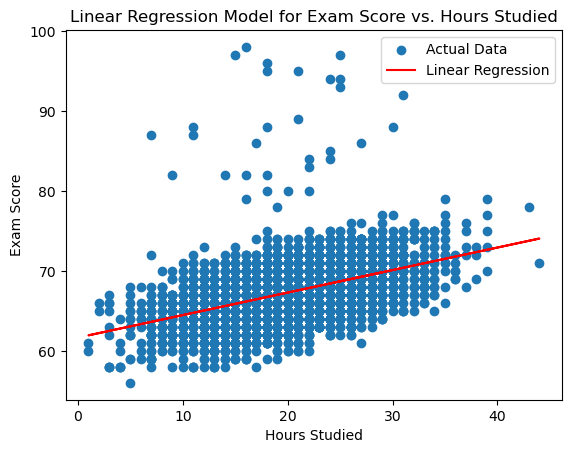

In [6]:
plt.scatter(x=df_train['Hours_Studied'],
            y=df_train['Exam_Score'],
            label='Actual Data')
plt.plot(df_train['Hours_Studied'],
         ls_area_fit.intercept_ + df_train['Hours_Studied'] * ls_area_fit.coef_[0],
         color='red',
         label='Linear Regression')
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.title('Linear Regression Model for Exam Score vs. Hours Studied')
plt.legend()
plt.show()

Evaluate it on the testing data.

In [7]:
# Create a DataFrame to compare true vs predicted values for validation data
pred_val_df = pd.DataFrame({
    'true': y_validation,
    'predicted': pred_val_df
})

# Display the comparison
print(pred_val_df.head())

      true  predicted
6332    65  68.418919
823     64  67.856129
6092    70  68.981710
4245    66  67.293339
1924    72  69.263105


In [8]:
ls_rmse = np.sqrt(mean_squared_error(pred_val_df['true'], pred_val_df['predicted']))
ls_mae = mean_absolute_error(pred_val_df['true'], pred_val_df['predicted'])
ls_mad = np.median(np.abs(pred_val_df['true'] - pred_val_df['predicted']))
ls_corr = np.corrcoef(pred_val_df['true'], pred_val_df['predicted'])[0, 1]
ls_r2 = r2_score(pred_val_df['true'], pred_val_df['predicted'])

print(f"LS RMSE: {ls_rmse}")
print(f"LS MAE: {ls_mae}")
print(f"LS MAD: {ls_mad}")
print(f"LS Correlation: {ls_corr}")
print(f"LS R²: {ls_r2}")

LS RMSE: 3.57147251843052
LS MAE: 2.507788728867084
LS MAD: 2.1677587569089525
LS Correlation: 0.45096142184109367
LS R²: 0.2015234091425332


Our correlation matches when we ran it in the previous check in last week.

Since the $R^2$ is so low alongside not a strong correlation, it would suggest the model is underfitting. It could be that it is not a strong enough model to predict between hours studied and exam score.

In [9]:
X = df_train['Hours_Studied'].values.reshape(-1,1)
# scale the predictors
X_std = (X - X.mean()) / X.std()
y = df_train['Exam_Score'].values.reshape(-1,1)

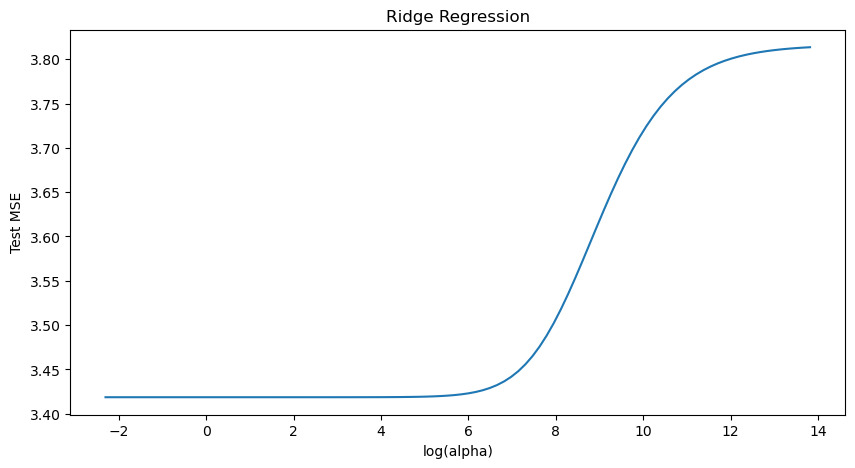

In [10]:
from sklearn.linear_model import  Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_validate

# use 10-fold cross-validation to select the best lambda (alpha) value for the ridge regression model

# define the alpha values to test
# note that the start/stop values in the first two arguments are the exponents
alphas = np.logspace(-1, 6, 100)

# create an empty list to store the cross-validation scores
ridge_cv_scores = []

# create a for loop to compute the cross-validation score for each alpha value
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge_cv = cross_validate(estimator=ridge,
                              X=X_std,
                              y=y,
                              cv=10,
                              scoring='neg_root_mean_squared_error')
    ridge_cv_scores.append({'alpha': alpha,
                            'log_alpha': np.log(alpha),
                            'test_mse': -np.mean(ridge_cv['test_score'])})

# convert the cross-validation scores into a data frame
ridge_cv_scores_df = pd.DataFrame(ridge_cv_scores)

plt.figure(figsize=(10, 5))
plt.plot(ridge_cv_scores_df['log_alpha'],
         ridge_cv_scores_df['test_mse'])

plt.xlabel('log(alpha)')
plt.ylabel('Test MSE')
plt.title('Ridge Regression')
plt.show()

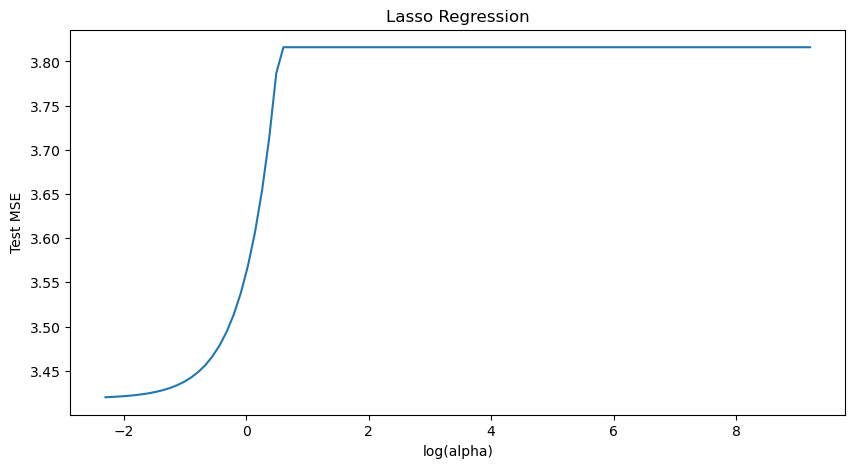

In [11]:
# use 10-fold cross-validation to select the best lambda (alpha) value for the lasso regression model

# define the alpha values to test
# note that the start/stop values in the first two arguments are the exponents
alphas = np.logspace(-1, 4, 100)

# create an empty list to store the cross-validation scores
lasso_cv_scores = []

# create a for loop to compute the cross-validation score for each alpha value
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso_cv = cross_validate(estimator=lasso,
                              X=X_std,
                              y=y,
                              cv=10,
                              scoring='neg_root_mean_squared_error')
    lasso_cv_scores.append({'alpha': alpha,
                            'log_alpha': np.log(alpha),
                            'test_mse': -np.mean(lasso_cv['test_score'])})

# convert the cross-validation scores into a data frame
lasso_cv_scores_df = pd.DataFrame(lasso_cv_scores)

# plot the cross-validation scores as a function of alpha
plt.figure(figsize=(10, 5))
plt.plot(lasso_cv_scores_df['log_alpha'],
         lasso_cv_scores_df['test_mse'])

plt.xlabel('log(alpha)')
plt.ylabel('Test MSE')
plt.title('Lasso Regression')
plt.show()

In [12]:
# fitting ridge model
ridge_alpha_min = ridge_cv_scores_df.sort_values(by='test_mse').head(1).alpha.values[0]
mse_se_ridge = ridge_cv_scores_df['test_mse'].std() / np.sqrt(10)
mse_min_ridge = ridge_cv_scores_df['test_mse'].min()
ridge_alpha_1se = ridge_cv_scores_df[(ridge_cv_scores_df['test_mse'] <= mse_min_ridge + mse_se_ridge) &
                                     (ridge_cv_scores_df['test_mse'] >= mse_min_ridge - mse_se_ridge)].sort_values(by='alpha', ascending=False).head(1).alpha.values[0]


#fitting lasso model
lasso_alpha_min = lasso_cv_scores_df.sort_values(by='test_mse').head(1).alpha.values[0]
mse_se_lasso = lasso_cv_scores_df['test_mse'].std() / np.sqrt(10)
mse_min_lasso = lasso_cv_scores_df['test_mse'].min()
lasso_alpha_1se = lasso_cv_scores_df[(lasso_cv_scores_df['test_mse'] <= mse_min_lasso + mse_se_lasso) &
                                     (lasso_cv_scores_df['test_mse'] >= mse_min_lasso - mse_se_lasso)].sort_values(by='alpha', ascending=False).head(1).alpha.values[0]

In [13]:
print('Ridge (min): ', ridge_alpha_min)
print('Ridge (1SE): ', ridge_alpha_1se)
print('Lasso (min): ', lasso_alpha_min)
print('Lasso (1SE): ', lasso_alpha_1se)

Ridge (min):  6.892612104349695
Ridge (1SE):  1747.5284000076829
Lasso (min):  0.1
Lasso (1SE):  0.5722367659350217


In [14]:
lasso_min_fit = Lasso(alpha=lasso_alpha_min).fit(X=X_std, y=y)
lasso_1se_fit = Lasso(alpha=lasso_alpha_1se).fit(X=X_std, y=y)

ridge_min_fit = Ridge(alpha=ridge_alpha_min).fit(X=X_std, y=y)
ridge_1se_fit = Ridge(alpha=ridge_alpha_1se).fit(X=X_std, y=y)

In [15]:
print(f"Lasso Min Model: {lasso_min_fit.intercept_[0]} + {lasso_min_fit.coef_[0]} * (Standardized) Hours Studied")
print(f"Lasso 1SE Model: {lasso_1se_fit.intercept_[0]} + {lasso_1se_fit.coef_[0]} * (Standardized) Hours Studied")
print(f"Ridge Min Model: {ridge_min_fit.intercept_[0]} + {ridge_min_fit.coef_[0][0]} * (Standardized) Hours Studied")
print(f"Ridge 1SE Model: {ridge_1se_fit.intercept_[0]} + {ridge_1se_fit.coef_[0][0]} * (Standardized) Hours Studied")

Lasso Min Model: 67.28453181583032 + 1.5996705268819853 * (Standardized) Hours Studied
Lasso 1SE Model: 67.28453181583032 + 1.1274337609469636 * (Standardized) Hours Studied
Ridge Min Model: 67.28453181583032 + 1.6966456122199114 * (Standardized) Hours Studied
Ridge 1SE Model: 67.28453181583032 + 1.1705518862105984 * (Standardized) Hours Studied


In [16]:
lasso_min_rmse = np.sqrt(mean_squared_error(y.reshape(-1, 1), lasso_min_fit.predict(X_std)))
lasso_min_corr = np.corrcoef(y.reshape(-1), lasso_min_fit.predict(X_std))[0, 1]
lasso_min_r2 = r2_score(y.reshape(-1, 1), lasso_min_fit.predict(X_std))

print(f"Lasso (Min) RMSE: {lasso_min_rmse}")
print(f"Lasso (Min) Correlation Coefficient: {lasso_min_corr}")
print(f"Lasso (Min) R^2: {lasso_min_r2}\n")

lasso_1s3_rmse = np.sqrt(mean_squared_error(y.reshape(-1, 1), lasso_1se_fit.predict(X_std)))
lasso_1se_corr = np.corrcoef(y.reshape(-1), lasso_1se_fit.predict(X_std))[0, 1]
lasso_1se_r2 = r2_score(y.reshape(-1, 1), lasso_1se_fit.predict(X_std))

print(f"Lasso (1SE) RMSE: {lasso_1s3_rmse}")
print(f"Lasso (1SE) Correlation Coefficient: {lasso_1se_corr}")
print(f"Lasso (1SE) R^2: {lasso_1se_r2}\n")

ridge_min_rmse = np.sqrt(mean_squared_error(y.reshape(-1, 1), ridge_min_fit.predict(X_std)))
ridge_min_corr = np.corrcoef(y.reshape(-1), ridge_min_fit.predict(X_std).reshape(-1))[0, 1]
ridge_min_r2 = r2_score(y.reshape(-1, 1), ridge_min_fit.predict(X_std))

print(f"Ridge (Min) RMSE: {lasso_min_rmse}")
print(f"Ridge (Min) Correlation Coefficient: {lasso_min_corr}")
print(f"Ridge (Min) R^2: {lasso_min_r2}\n")

ridge_1se_rmse = np.sqrt(mean_squared_error(y.reshape(-1, 1), ridge_1se_fit.predict(X_std)))
ridge_1se_corr = np.corrcoef(y.reshape(-1), ridge_1se_fit.predict(X_std).reshape(-1))[0, 1]
ridge_1se_r2 = r2_score(y.reshape(-1, 1), ridge_1se_fit.predict(X_std))

print(f"Ridge (1SE) RMSE: {lasso_min_rmse}")
print(f"Ridge (1SE) Correlation Coefficient: {lasso_min_corr}")
print(f"Ridge (1SE) R^2: {lasso_min_r2}\n")

Lasso (Min) RMSE: 3.4267618338079435
Lasso (Min) Correlation Coefficient: 0.444495780036996
Lasso (Min) R^2: 0.19689257769408797

Lasso (1SE) RMSE: 3.472772895242439
Lasso (1SE) Correlation Coefficient: 0.4444957800369967
Lasso (1SE) R^2: 0.17518117640547648

Ridge (Min) RMSE: 3.4267618338079435
Ridge (Min) Correlation Coefficient: 0.444495780036996
Ridge (Min) R^2: 0.19689257769408797

Ridge (1SE) RMSE: 3.4267618338079435
Ridge (1SE) Correlation Coefficient: 0.444495780036996
Ridge (1SE) R^2: 0.19689257769408797



These models show basically no improvement from the linear regression model above. In fact, The $R^2$ values of these models are actually worse than the linear regression model.

The scatterplots show a similar story, with no visible improvement in the model.

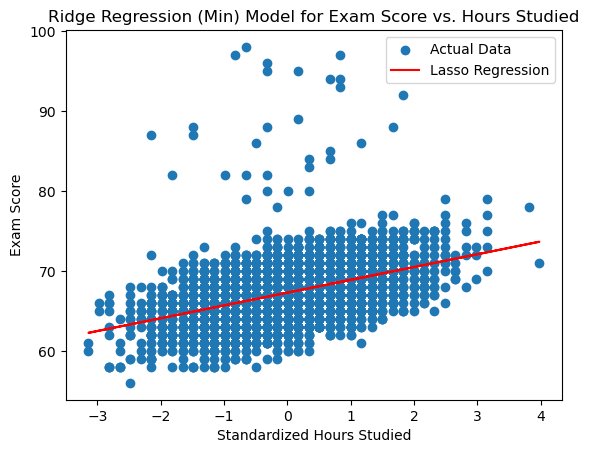

In [17]:
plt.scatter(X_std, y, label='Actual Data')
plt.plot(X_std,
         lasso_min_fit.intercept_ + X_std * lasso_min_fit.coef_[0],
         label = 'Lasso Regression',
         color='red')
plt.xlabel('Standardized Hours Studied')
plt.ylabel('Exam Score')
plt.title('Ridge Regression (Min) Model for Exam Score vs. Hours Studied')
plt.legend()
plt.show()

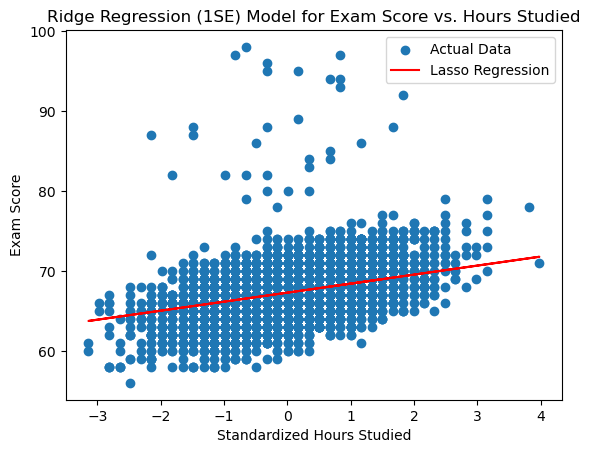

In [18]:
plt.scatter(X_std, y, label='Actual Data')
plt.plot(X_std,
         lasso_1se_fit.intercept_ + X_std * lasso_1se_fit.coef_[0],
         label = 'Lasso Regression',
         color='red')
plt.xlabel('Standardized Hours Studied')
plt.ylabel('Exam Score')
plt.title('Ridge Regression (1SE) Model for Exam Score vs. Hours Studied')
plt.legend()
plt.show()

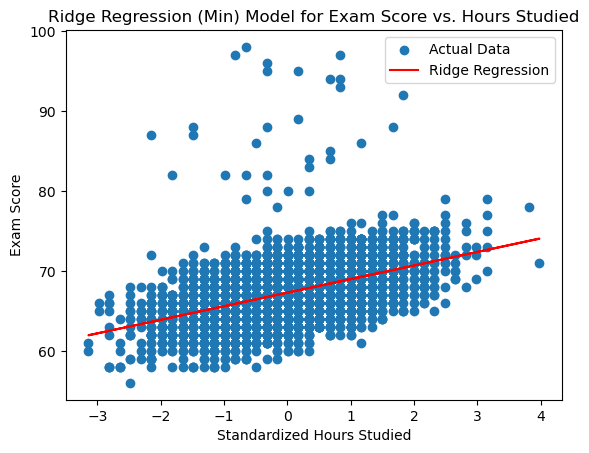

In [19]:
plt.scatter(X_std, y, label='Actual Data')
plt.plot(X_std,
         ridge_min_fit.intercept_ + X_std * ridge_min_fit.coef_[0],
         label = 'Ridge Regression',
         color='red')
plt.xlabel('Standardized Hours Studied')
plt.ylabel('Exam Score')
plt.title('Ridge Regression (Min) Model for Exam Score vs. Hours Studied')
plt.legend()
plt.show()

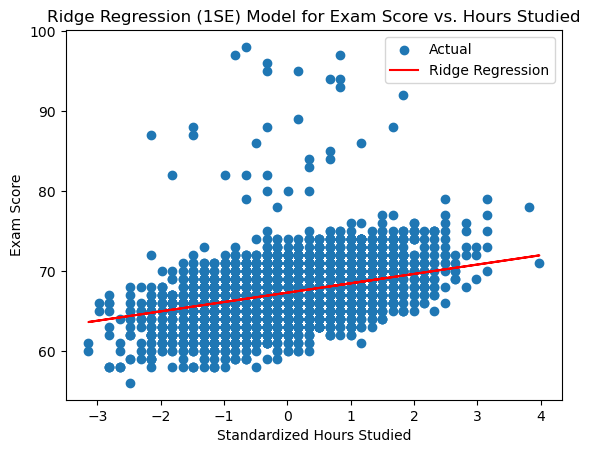

In [20]:
plt.scatter(X_std, y, label='Actual')
plt.plot(X_std,
         ridge_1se_fit.intercept_ + X_std * ridge_1se_fit.coef_[0],
         label = 'Ridge Regression',
         color='red')
plt.xlabel('Standardized Hours Studied')
plt.ylabel('Exam Score')
plt.title('Ridge Regression (1SE) Model for Exam Score vs. Hours Studied')
plt.legend()
plt.show()